In [56]:
# UNIVERSIDAD LATINA DE PANAMÁ - 2024-1 / INTELIGENCIA ARTIFICIAL

#Lab 3 grupo 4

In [9]:
# Instalamos esta dependencia que es necesaria en un punto
!pip install pillow
!pip install opencv-python

In [10]:
#Listado de Librerías

import pandas as pd
import numpy as np
import os
import tempfile
import PIL

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from zipfile import ZipFile
from PIL import Image
from numpy.random import randint

In [ ]:
# Para tener repitividad en los resultados generados

np.random.seed(42)

# Creamos un directorio temporal
d = tempfile.mkdtemp()

# Definimos el URL
url = 'https://github.com/Aleriveraa08/plantitas/blob/main/Plants_2.zip'

# Tenemos la data
fn, info = urlretrieve(url, os.path.join(d, 'Plants_2.zip'))

In [13]:
print("[INFO] Creada carpeta temporal en:", fn)
print("[INFO] Mi directorio actual de trabajo es:", os.getcwd())

[INFO] Creada carpeta temporal en: /tmp/tmpbtwdmuca/Plants_2.zip
[INFO] Mi directorio actual de trabajo es: /content


In [15]:
#Creación de carpeta para contenido del ZIP con plantas

myimagedir = os.path.join(os.getcwd(), '/content/DATASETS\LAB 3\Leaves')
if not os.path.exists(myimagedir):
    os.mkdir(myimagedir)

file_name='/content/Plants_2.zip'

with ZipFile(file_name, 'r') as zip:
    zip.extractall(path=myimagedir, members=None,)
    zip.close()

In [16]:
#Remover el directorio temporal
os.remove(fn)
os.rmdir(d)

In [39]:
#Separación de las imágenes a utilizar del dataset, la carpeta "images to predict"

img_predict= '/content/DATASETS\LAB 3\Leaves/Plants_2/images to predict'
jpeglist = os.listdir(img_predict)

i = 0
with open('labels.txt', 'w') as lbl:
    for _r in jpeglist:
        i = i + 1
        if i <= 66:
            leafclass = 0
        if i > 66 and i <= 126:
            leafclass = 1
        if i > 126:
            leafclass = 2
        lbl.write(str(leafclass) + '\n')
lbl.close()

In [40]:
## I. LEAF DATASET:

#Conteo de la cantidad de imágenes a utilizar

target = np.genfromtxt('labels.txt').astype(np.uint8)
target.shape

(180,)

In [ ]:
#Primer procesamiento de imágenes convirtiéndolo en una arreglo con imágenes de dimensiones 896x592 y 3 canales

w       = 896
h       = 597
nimages = 180
nchan   = 3

imgarr   = np.zeros((w*h*nchan, nimages), dtype=np.uint8)

for index, filename in enumerate(os.listdir(img_predict)):
    img = PIL.Image.open(os.path.join(img_predict, filename))
    pixels = np.array(img).reshape(w*h*nchan)
    imgarr[:, index] = pixels


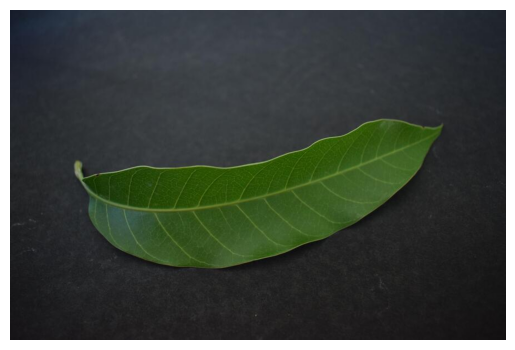

In [44]:
# Ahora imprimiremos una hoja aleatorea

some_leaf = imgarr[:, randint(0, 180)].reshape(597, 896, 3)
plt.imshow(some_leaf)
plt.axis("off")
plt.show()

In [45]:
# Por convenencia dividimos en tres clases iguales de mismo tamaño.
# Como todas las clases tendrán la misma cantidad de datos, vamos a emparejarlas solamente para poder dividir mejor el dataset

X = imgarr
Y = target
Y = np.hstack((Y[:60], Y[66:]))
X = np.hstack((X[:, :60], X[:, 66:]))
X.shape, Y.shape

((1604736, 174), (174,))

In [46]:
# Dividimos ahora el training set y el test set
nimginclass = 60
train = int(0.8*60)
test = 60 - train

# La primera clase va de 0 a 48, la segunda de 60 a 119 y la ultima de 120 a 180
# Sin embargo son de 0 a 47 imagenes de training y de 48 a 59 para test para cada clase

Xtrain = np.hstack((X[:,   :48], X[:, 60:(60+48)], X[:, 120:(120+48)]))/255
Ytrain = np.hstack((Y[:48], Y[60:(60+48)], Y[120:(120+48)]))

Xtest  = np.hstack((X[:, 48:(48+12)], X[:, (60+48):(60+48+12)], X[:, (120+48):]))/255
Ytest  = np.hstack((Y[48:(48+12)], Y[(60+48):(60+48+12)], Y[(120+48):]))

#Imprimimos las divisiones como verificación

Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((1604736, 144), (1604736, 30), (144,), (30,))

In [47]:
#II. Clasificación Multiclase

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(Xtrain.T, Ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5, random_state=42)

In [48]:
#Impresión de las predicciones respecto al test

Ypredict = sgd_clf.predict(Xtest.T)
Ypredict, Ytest

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2], dtype=uint8))

In [49]:
#Ahora utilizaremos una métrica para el rendimiento de la predicción llamada validación cruzada.
#Esta función evalua el modelo utilizado usando validación cruzada con k-fold

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for xindex, yindex in kfold.split(Xtrain.T, Ytrain):
    clonemodel  = clone(sgd_clf)
    Xtrainfold = Xtrain.T[xindex]
    Ytrainfold = (Ytrain[xindex])
    Xtestfold  = Xtrain.T[yindex]
    Ytestfold  = (Ytrain[yindex])

    clonemodel.fit(Xtrainfold, Ytrainfold)
    prediction = clonemodel.predict(Xtestfold)
    numok = sum(prediction == Ytestfold)
    print(numok / len(prediction))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.4791666666666667
0.4583333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [50]:
#Visto con la métrica de cross_validation para observar que tan bien o mal lo hizo nuestro dataset.

cross_val_score(sgd_clf, Xtrain.T, Ytrain, cv=3, scoring="accuracy")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.66666667, 0.4375    , 0.33333333])

In [51]:
#Evaluación del modelo en base a la matriz de confusión.

from sklearn.metrics import confusion_matrix

Ypredictions = cross_val_predict(sgd_clf, Xtrain.T, Ytrain, cv=3)

confMat = confusion_matrix(Ytrain, Ypredictions)
confMat

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[21, 27,  0],
       [ 0, 48,  0],
       [ 0, 48,  0]])

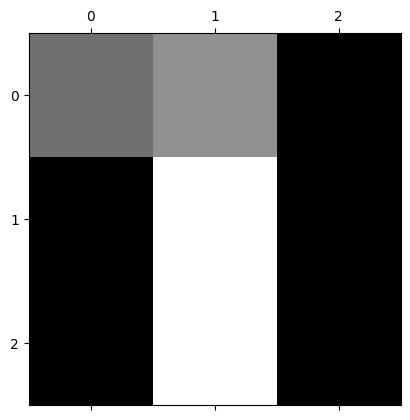

In [52]:
#Visto con colores...

plt.matshow(confMat, cmap=plt.cm.gray)
plt.show()

In [53]:
#MÉTRICAS DE CLASIFICACIÓN BINARIA

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_score(Ytrain, Ypredictions, average='micro')

0.4791666666666667

In [54]:
recall_score(Ytrain, Ypredictions, average='micro')

0.4791666666666667

In [55]:
f1_score(Ytrain, Ypredictions, average='micro')

0.4791666666666667